In [90]:
import pandas as pd
import os
import re
import geopandas
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Party-Lists of the 2019 Elections: The Winners and The Real Score 

Party-list representation in Congress is integrated in our politics to give voice to the people at the margins of our society, to raise special interests in crafting and debating policies, and to bring forth unique insights to a national forum. However, in every election, party-list representation is generally met with cynicism, indifference, and legitimate doubt. Who are they? What are they for? Should they win, will they truly fulfil the essence of their mandate? 

Here we will explore the last question. We're taking a closer look to some of the winners of the party-list race in the recent 2019 elections, specifically the distribution of the votes they got across all provinces and whether those votes are reflective of the sectors they supposedly represent. 


In [ ]:
"""
Data Wrangling
"""

"""
The files are extracted from the COMELEC central server. The specific files
processed here are the COC and the contest JSON files pertaining to the 2019
national election database. 

In the COC files, the rs data which contains both the contest 
codes, candidate ballot order, votes and the percentage of votes are 
processed. On the other hand, in the contest files, the contest codes and the 
corresponding candidate information were processed.

Census data are extracted from excel files of PSA. The data specifically 
extracted are the occupation groups.
"""

In [3]:
path = '/mnt/data/public/elections/nle2019/results/'
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if 'coc.json' in file:
            files.append(os.path.join(r, file))

# Process all municipal COCs into a consolidated DataFrame

rs_df = pd.DataFrame()
cos_df = pd.DataFrame()
for filepath in files:
    with open(filepath, 'r') as f:
        jsontext = f.read()
        jsondict = json.loads(jsontext)

    remun = re.findall(r'results\/(.*?)\/coc.json', filepath)

    rs_df0 = pd.DataFrame()
    for i in jsondict['rs']:
        i['mun'] = remun
        rs_dfi = pd.DataFrame(i, index=[0])
        rs_df0 = rs_df0.append(rs_dfi)

    rs_df = rs_df.append(rs_df0)

    cos_df0 = pd.DataFrame()
    for i in jsondict['cos']:
        i['mun'] = remun
        cos_dfi = pd.DataFrame(i, index=[0])
        cos_df0 = cos_df0.append(cos_dfi)

    cos_df = cos_df.append(cos_df0)

rs_df.to_json('rs_df.json', orient='split')
cos_df.to_json('cos_df.json', orient='split')

# Get from the contests directory the contest and the candidates data

df_contest = pd.DataFrame()
df_candidates = pd.DataFrame()
path = '/mnt/data/public/elections/nle2019/contests/'
for jsonfile in os.listdir(path):
    with open(f"{path}/{jsonfile}") as f:
        data = f.read()
    jsondict = json.loads(data)
    jsondict_no_boc = jsondict.copy()
    jsondict_no_boc.pop('bos')
    df_contest = df_contest.append(pd.DataFrame(jsondict_no_boc, index=[0]))
    for i in jsondict['bos']:
        df_candidates = df_candidates.append(
            pd.DataFrame(i, index=[jsondict['cc']]))

df_contest.to_json('contest_data.json', orient='split')
df_candidates.to_json('candidate_data.json', orient='split')

In [3]:
# Extract the occupation data from the census

rs_df_reload = pd.read_json('rs_df.json', orient='split')
cen_fi = [re.findall(r'_?(.*?)_Statistical', i)[0]
          for i in os.listdir('/mnt/data/public/census/')]

df_proall = pd.DataFrame()
for filepath in os.listdir('/mnt/data/public/census/'):
    df_cen = pd.read_excel('/mnt/data/public/census/'+filepath,
                           sheet_name='T13', header=2, usecols=[0, 1],
                           names=['group', 'count'])
    df_cen = df_cen.dropna(thresh=1).reset_index(drop=True)
    ind = list(zip(df_cen.loc[df_cen['group'] == 'Both Sexes'].index,
                   df_cen.loc[df_cen['group'] == 'Male'].index))
    df_pro = pd.DataFrame()
    for s, e in ind:
        df_pro_r = df_cen.iloc[s:e]
        df_pro_r.insert(0, 'area', df_cen.iloc[s-1]['group'])
        df_pro_r.insert(3, 'total', df_cen.iloc[s]['count'])
        df_pro = df_pro.append(df_pro_r)
        break
    df_proall = df_proall.append(df_pro)

# Remove all the regional data (focus only on the provincial and major cities)

df_proall = df_proall[df_proall['area'].apply(
    lambda x: not bool(re.search('REGION', x)))]
df_proall['percent'] = 100*df_proall['count']/df_proall['total']

df_plr = rs_df_reload[rs_df_reload['cc'] == 5567]
df_plrreg = df_plr[df_plr['mun'].apply(lambda x:
                                       bool(re.match(r'^[^\/]*?\/[^\/]*?$',
                                                     x))
                                       or bool(re.match(r'^NCR.*?$', x)))]

df_con = pd.read_json('contest_data.json', orient='split')
df_can = pd.read_json('candidate_data.json', orient='split')

# List all the party-lists of interest

plr_uniform_n = ['130 SENIOR CITIZENS', '3 MAGSASAKA', '83 ACT TEACHERS']
plr_uniform = list(df_can[df_can.bon.isin(plr_uniform_n)].boc.values)

plr_natural_n = ['141 AKO BICOL', '43 AN WARAY', '9 KUSUG TAUSUG']
plr_natural = list(df_can[df_can.bon.isin(plr_natural_n)].boc.values)

plr_unnatural_n = ['29 BAHAY', '172 PHILRECA', '76 ABONO']
plr_unnatural = list(df_can[df_can.bon.isin(plr_unnatural_n)].boc.values)

# Construct dataframes containing each of the party-list groups

df_plrreg_uni = df_plrreg[df_plrreg['bo'].apply(lambda x: x in plr_uniform)]
df_plrreg_uni['bo'] = df_plrreg_uni['bo'].apply(
    lambda x: f'{plr_uniform.index(x)+1:02d}-{x}')
df_plrreg_uni['bo'] = df_plrreg_uni['bo'].apply(lambda x: re.match(r'(.*)-.*',
                                                                   x).group(
    1)+'-'+df_can[df_can['boc'] == int(re.match(r'.*-(.*)', x).group(1))][
    'bon'].to_numpy()[0])
df_plrreg_nat = df_plrreg[df_plrreg['bo'].apply(lambda x: x in plr_natural)]
df_plrreg_nat['bo'] = df_plrreg_nat['bo'].apply(
    lambda x: f'{plr_natural.index(x)+1:02d}-{x}')
df_plrreg_nat['bo'] = df_plrreg_nat['bo'].apply(lambda x: re.match(r'(.*)-.*',
                                                                   x).group(
    1)+'-'+df_can[df_can['boc'] == int(re.match(r'.*-(.*)', x).group(1))][
    'bon'].to_numpy()[0])

df_plrreg_unnat = df_plrreg[df_plrreg['bo'].apply(
    lambda x: x in plr_unnatural)]
df_plrreg_unnat['bo'] = df_plrreg_unnat['bo'].apply(
    lambda x: f'{plr_unnatural.index(x)+1:02d}-{x}')
df_plrreg_unnat['bo'] = df_plrreg_unnat[
    'bo'].apply(lambda x: re.match(r'(.*)-.*', x).group(1)
                + '-'+df_can[df_can['boc'] == int(re.match(r'.*-(.*)',
                                                           x).group(1))][
                    'bon'].to_numpy()[0])

df_plrreg_outlier = df_plrreg_nat.append(df_plrreg_unnat)

### The Winners: An Overview of Votes Distribution 

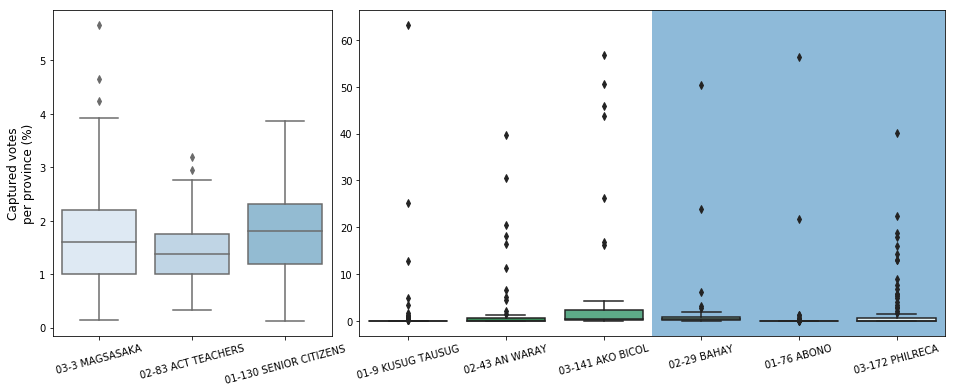

In [91]:
# Plot the voter distribution of the party-lists across different provinces
# using boxplots.

df_plrreg_pivot = df_plrreg_uni[['bo', 'mun', 
                                 'per']].pivot_table(columns='bo', 
                                                     values='per',
                                                     index='mun')
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 3, wspace=0.1, figure=fig)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1:3])
sns.boxplot(x='bo', y='per', data=df_plrreg_uni,
            palette=sns.color_palette("Blues"), ax=ax1)
ax2.axvspan(2.5, 5.5, alpha=0.5, zorder=0)
sns.boxplot(x='bo', y='per', data=df_plrreg_outlier,
            palette=sns.color_palette("BuGn_r"), ax=ax2)
ax1.set_xticklabels(labels=ax1.get_xmajorticklabels(),
                    rotation=15)  # , ha='right')
ax2.set_xticklabels(labels=ax2.get_xmajorticklabels(),
                    rotation=15)  # , ha='right')
ax1.set_ylabel('Captured votes\nper province (%)', size=12)
ax2.set_ylabel(None)
ax1.set_xlabel(None)
ax2.set_xlabel(None)

### Winners: Magsasaka, ACT-Teachers, Senior Citizens<br/>Score:  The True Margins

Minorities and special interests are spread across the nation. Youth and women, for example, are everywhere in the country. And so are groups such as teachers and senior citizens. For the party-lists representing these groups, it is only natural that their captured voters are from everywhere as well.  

Such is the case for Magsasaka, ACT-Teachers and Senior Citizens. The boxplots showing the distribution of percentage of votes for these three party-lists demonstrates normality. The spread is small, the median is close to the national aggregate, and most importantly, there are few to no outliers. This means that there are no specific provinces which drove the votes and earned them their seats. 

In [ ]:
# Prepare the dataframes of the agricultural workers census data, MAGSASAKA 
# and ABONO to match the shape files containing the Philippine map and merge
# the geopandas dataframe.

ph1 = geopandas.GeoDataFrame.from_file('gadm36_PHL_1.shp')

df_plrreg['prov'] = df_plrreg['mun'].str.split('/').str[1]
df_plrreg_outlier['prov'] = df_plrreg_outlier['mun'].str.split('/').str[1]

df_magsasaka = df_plrreg[df_plrreg['bo'] == df_can[df_can.bon.str.endswith(
    'MAGSASAKA')]['boc'].iloc[0]]
ph1['NAME_1'] = ph1['NAME_1'].str.upper()
merged_magsasaka = ph1.merge(df_magsasaka[['prov', 'per']], left_on='NAME_1',
                             right_on='prov')

df_agri = df_proall[df_proall['group'] ==
                    'Skilled Agricultural Forestry and Fishery Workers']
merged_agri = ph1.merge(df_agri[['area', 'percent']], left_on='NAME_1',
                        right_on='area')

df_abono = df_plrreg[df_plrreg['bo'] == df_can[df_can.bon.str.endswith(
    'ABONO')]['boc'].iloc[0]]
merged_abono = ph1.merge(df_abono[['prov', 'per']], left_on='NAME_1',
                         right_on='prov')

To further illustrate this point, we take the case of Magsasaka, a party-list representing and advocating the welfare of farmers. The following figures shows the geographic spread of votes for Magsasaka in different provinces, as well as the geographic map of which provinces in the country are the most agricultural. For most of the provinces in Luzon and Visayas, the density of the votes corresponds with the density of the agricultural population.  Compare this for example with Abono, another winning party-list also supposedly representing the farmers sector. There is no correlation at all, and the votes are focused on just a specific region – but more on this later. 

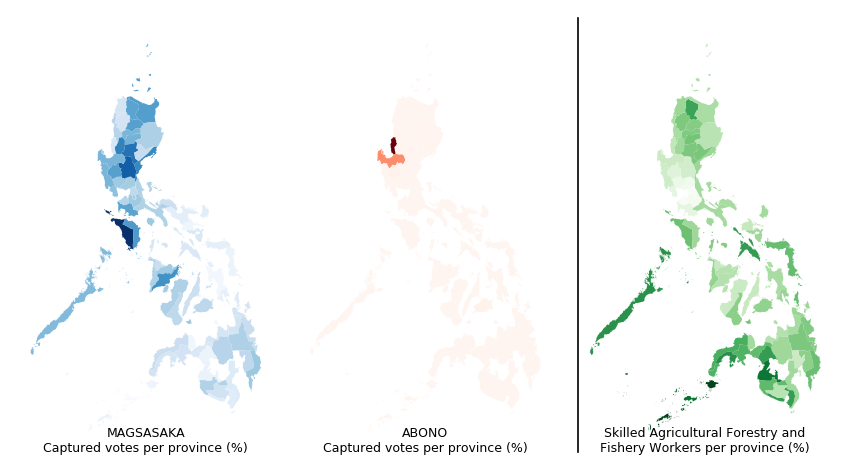

In [97]:
# Generate the choropleth for the captured votes of the different provinces
# for ABONO, MAGSASAKA, and agricultural workers census data.

colors = 5
cmap_b = 'Blues'
cmap_g = 'Greens'
cmap_r = 'Reds'
fig, ax = plt.subplots(1, 3, figsize=(7, 5), dpi=150,
                       gridspec_kw={'wspace': 0.1})
ax[0].set_title("MAGSASAKA\nCaptured votes per province (%)",
                fontsize=6, y=-0.03)
ax[1].set_title("ABONO\nCaptured votes per province (%)", fontsize=6, y=-0.03)
ax[2].set_title("Skilled Agricultural Forestry and\nFishery Workers per "
                "province (%)", fontsize=6, y=-0.03)
base1 = merged_magsasaka.plot(column='per', ax=ax[0], cmap=cmap_b,
                              figsize=fig, k=colors)
base2 = merged_abono.plot(column='per', ax=ax[1], cmap=cmap_r, figsize=fig,
                          k=colors)
base3 = merged_agri.plot(column='percent', ax=ax[2], cmap=cmap_g, figsize=fig,
                         k=colors)

for i in range(3):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)

    ax[i].tick_params(axis='x', which='both', bottom=False, top=False,
                      labelbottom=False)
    ax[i].tick_params(axis='y', which='both', right=False, left=False,
                      labelleft=False)
ax[2].spines['left'].set_visible(True)

### Winners: Ako Bicol, An Waray, Kusug Tausug <br/>Score: The Ethnic Groups

Another case will be the groups clearly and explicitly representing ethnic groups. These groups are usually residing in specific regions in the country, and so it is but natural that their captured votes will mostly come from the same regions as well. A quick look on the spread of their votes confirms this. 

In [ ]:
# Prepare the dataframes of the KUSUG TAUSUG, AN WARAY, and AKO BICOL to match
# the shape files containing the Philippine map and merge the geopandas
# dataframe.

df_tausug = df_plrreg_outlier[df_plrreg_outlier['bo'].str.endswith('TAUSUG')]
merged_tausug = ph1.merge(
    df_tausug[['prov', 'per']], left_on='NAME_1', right_on='prov')
df_tausug = df_tausug.sort_values(by='per', ascending=False)[
    :5][['bo', 'v', 'per', 'mun']]

df_waray = df_plrreg_outlier[df_plrreg_outlier['bo'].str.endswith('WARAY')]
merged_waray = ph1.merge(
    df_waray[['prov', 'per']], left_on='NAME_1', right_on='prov')
df_waray = df_waray.sort_values(by='per', ascending=False)[
    :5][['bo', 'v', 'per', 'mun']]

df_bicol = df_plrreg_outlier[df_plrreg_outlier['bo'].str.endswith('BICOL')]
merged_bicol = ph1.merge(
    df_bicol[['prov', 'per']], left_on='NAME_1', right_on='prov')
df_bicol = df_bicol.sort_values(by='per', ascending=False)[
    :5][['bo', 'v', 'per', 'mun']]

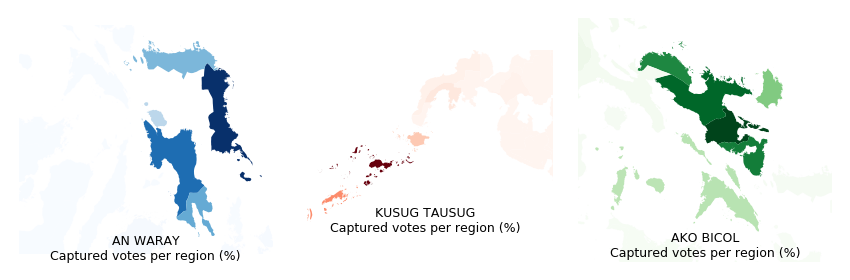

In [32]:
# Generate the choropleth for the captured votes of the different provinces
# for KUSUG TAUSUG, AN WARAY, and AKO BICOL


colors = 5
cmap_b = 'Blues'
cmap_g = 'Greens'
cmap_r = 'Reds'
fig, ax = plt.subplots(1, 3, figsize=(7, 5), dpi=150,
                       gridspec_kw={'wspace': 0.1})
ax[0].set_title("AN WARAY\nCaptured votes per region (%)", fontsize=6, y=-0.08)
ax[1].set_title("KUSUG TAUSUG\nCaptured votes per region (%)",
                fontsize=6, y=-0.08)
ax[2].set_title("AKO BICOL\nCaptured votes per region (%)",
                fontsize=6, y=-0.03)
base1 = merged_tausug.plot(column='per', ax=ax[1], cmap=cmap_r, figsize=fig,
                           k=colors)
base2 = merged_waray.plot(column='per', ax=ax[0], cmap=cmap_b, figsize=fig,
                          k=colors)
base3 = merged_bicol.plot(column='per', ax=ax[2], cmap=cmap_g, figsize=fig,
                          k=colors)

ax[1].set_xlim(119.169581, 125.289922)
ax[1].set_ylim(4.400598, 8.726143)
ax[0].set_xlim(122.502876, 126.126222)
ax[0].set_ylim(9.648632, 12.908103)
ax[2].set_xlim(121.430993, 125.143240)
ax[2].set_ylim(11.282545, 14.833511)

for i in range(3):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)

    ax[i].tick_params(axis='x', which='both', bottom=False,
                      top=False, labelbottom=False)
    ax[i].tick_params(axis='y', which='both', right=False,
                      left=False, labelleft=False)

### Winners: Abono, Bahay, Philreco<br/>Score: The Posers

The last case of winners is the most controversial, and justifiably, the most questionable ones. This is when most of the votes for the party-lists come from very few specific areas only even if they're supposedly representing a special interest or marginalized group of the national scale. This is immediately apparent on their corresponding boxplots showing their votes distribution. The outliers for these are very far and significant enough. 

Abono – the case taken up early – is a clear case of this. The other examples are Bahay, a party-list advocating housing for all Filipinos, and Philreca, a party-list representing rural electric cooperatives. These party-lists got more than 20% of votes from neighboring provinces. Abono got the La Union-Pangasinan votes, Bahay the Camiguin-Lanao del Sur, and Philreca the North Luzon provinces.  

Because of this, it seems that they're representing specific provinces rather than their supposed advocacy or sector.  It is also easy to see that this is one if not the most crucial of the criticisms in the current party-lists representation. The party-lists seats devolve to be mere extensions of existing provincial representatives (and in some cases, of existing provincial dynasties), and in consequence, depriving seats – and voice – for the truly marginalized. 

In [53]:
# Extract the top five provinces for the ABONO, PHILRECA and BAHAY party-lists
# based on the percentage of captured votes.

df_abono = df_plrreg_outlier[df_plrreg_outlier['bo'].str.endswith('ABONO')]
df_abono = df_abono.sort_values(by='per', ascending=False)[
    :5][['v', 'per', 'mun']]

df_philreca = df_plrreg_outlier[df_plrreg_outlier['bo'].str.endswith(
    'PHILRECA')]
df_philreca = df_philreca.sort_values(by='per', ascending=False)[
    :5][['v', 'per', 'mun']]

df_bahay = df_plrreg_outlier[df_plrreg_outlier['bo'].str.endswith('BAHAY')]
df_bahay = df_bahay.sort_values(by='per', ascending=False)[
    :5][['v', 'per', 'mun']]
df_bahay['mun'] = df_bahay['mun'].str.replace('NATIONAL CAPITAL REGION', 'NCR')
df_bahay['mun'] = df_bahay['mun'].str.replace(r'NCR.* DISTRICT', 'NCR ')

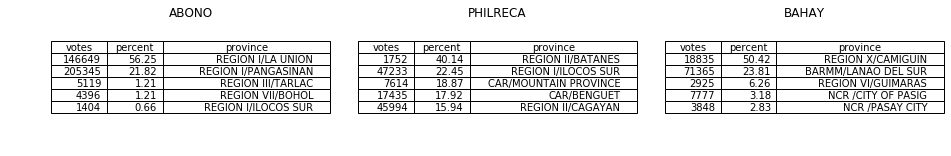

In [93]:
# Show the dataframes as matplotlib tables

fig, ax = plt.subplots(1, 3, figsize=(16, 2), gridspec_kw={
                       'wspace': 0.1, 'hspace': -0.01})

for i in range(3):
    ax[i].axis('off')
    ax[i].axis('tight')

ax[0].table(cellText=df_abono.values, colLabels=['votes', 'percent',
                                                 'province'], loc='center',
            colWidths=[0.2, 0.2, 0.6])
ax[1].table(cellText=df_philreca.values, colLabels=['votes', 'percent',
                                                    'province'], loc='center',
            colWidths=[0.2, 0.2, 0.6])
ax[2].table(cellText=df_bahay.values, colLabels=['votes', 'percent',
                                                 'province'], loc='center',
            colWidths=[0.2, 0.2, 0.6])

ax[0].set_title("ABONO")
ax[1].set_title("PHILRECA")
ax[2].set_title("BAHAY")

### Conclusion

From our analysis of the winning party-lists, we can divide them into two main groups: those with uniform distribution, i.e. their captured voters are spread across the country, and those that won due to certain provinces.

The group with voters across the country like Magsasaka, when compared with their represented sector - the farmers, has shown similar population spread across the map. For this group, the party-list properly represents their respective target sector.

For the second group that won due to certain provinces, it can be further divided into two subgroups: those that actually represent a certain region and those that do not. For those that represent a certain region that won due to that region, this result is natural but the necessity of such a party-list is dependent on whether its purpose conflicts with other existing government positions like district congressman. Lastly for the party-lists representing a sector that is spread across the country but only gathers support from few provinces, the party-lists merely become an extension of the existing provincial representatives.

It can be seen that the current party-list system is incapable of fulfilling the purpose of the party-list system to some extent. Therefore, steps should be taken in order to make the system more critical of the proposed representation of each party-list in order to properly give voice to the margins of the society. 

In [85]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

Sources: 

https://www.comelec.gov.ph/php-tpls-attachments/2019NLE/ListsOfCandidates/CertifiedListofCandidates/NATIONAL/PARTYLIST.pdf 